# Chapter 3: Parallelization

여러 개의 컴포넌트(마치 Like LLM 호출, 도구 사용, 혹은 하위 에이전트)를 동시에 실행하는 것을 의미한다.
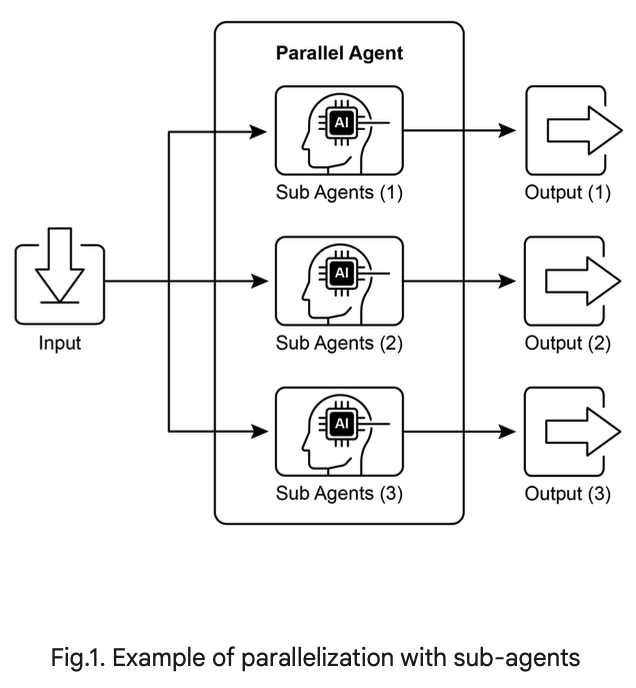

한 단계가 끝나는 걸 기다리지 않고, 독립적인 태스크 들을 동시에 실행함으로써 전체 수행 시간을 크게 단축할 수 있다

코어 아이디어는 워크플로우 내에서 서로의 출력에 의존하지 않는 부분들을 식별하고, 그 부분들을 병렬로 실행하는 것이다.
latency가 발생하는 외부 서비스 들을 다룰 때 효과적이다. 여러 요청을 동시에 보내 처리할 수 있어서, 전체 실행 시간을 크게 줄일 수 있다.

In [5]:
from __future__ import annotations

import asyncio
from typing import TypedDict, Optional

from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

from llm import LocalLLM

In [3]:
class ParallelState(TypedDict, total=False):
    topic: str
    summary: str
    questions: str
    key_terms: str
    synthesis: str # 최종 결과

llm = LocalLLM()

In [4]:
def summarize_node(state: ParallelState) -> ParallelState:
    topic = state["topic"]
    prompt = (
        "당신은 요약 전문가입니다. 아래 주제를 한국어로 2-3문장으로 간결히 요약하세요.\n\n"
        f"주제: {topic}"
    )
    txt = llm.chat(prompt=prompt)
    return {"summary": txt}

def questions_node(state: ParallelState) -> ParallelState:
    topic = state["topic"]
    prompt = (
        "당신은 질문 생성 전문가입니다. 아래 주제에 대해 한국어로 흥미로운 질문 3가지를 "
        "하나의 문단이 아닌 줄바꿈으로 구분하여 생성하세요.\n\n"
        f"주제: {topic}"
    )
    txt = llm.chat(prompt=prompt)
    return {"questions": txt}

def key_terms_node(state: ParallelState) -> ParallelState:
    topic = state["topic"]
    prompt = (
        "당신은 키워드 추출 비서입니다. 아래 주제에서 핵심 용어 5-10개를 한국어로 추출하고, "
        "쉼표로 구분하여 한 줄로만 출력하세요.\n\n"
        f"주제: {topic}"
    )
    txt = llm.chat(prompt=prompt)
    return {"key_terms": txt}

# 최종 합성 노드
def synthesis_node(state: ParallelState) -> ParallelState:
    summary = state.get("summary", "")
    questions = state.get("questions", "")
    key_terms = state.get("key_terms", "")
    topic = state["topic"]

    prompt = (
        "당신은 편집 전문가입니다. 아래 정보를 바탕으로 한국어로 일관된 최종 요약을 작성하세요.\n"
        "- 요약, 질문, 핵심 용어를 자연스럽게 녹여 6-8문장 내로 정리하되, 중복은 줄이세요.\n"
        "- 마지막에 '핵심 용어' 섹션을 만들고, key_terms를 보기 좋게 정돈해 제시하세요.\n\n"
        f"원 주제: {topic}\n\n"
        f"요약: {summary}\n"
        f"질문: {questions}\n"
        f"핵심 용어: {key_terms}\n"
    )
    txt = llm.chat(prompt=prompt)
    return {"synthesis": txt}

In [6]:
def build_graph():
    graph = StateGraph(ParallelState)

    graph.add_node("summarize", summarize_node)
    graph.add_node("questions", questions_node)
    graph.add_node("key_terms", key_terms_node)
    graph.add_node("synthesis", synthesis_node)

    graph.add_edge(START, "summarize")
    graph.add_edge(START, "questions")
    graph.add_edge(START, "key_terms")

    graph.add_edge("summarize", "synthesis")
    graph.add_edge("questions", "synthesis")
    graph.add_edge("key_terms", "synthesis")
    graph.add_edge("synthesis", END)

    memory = MemorySaver()
    return graph.compile(checkpointer=memory)

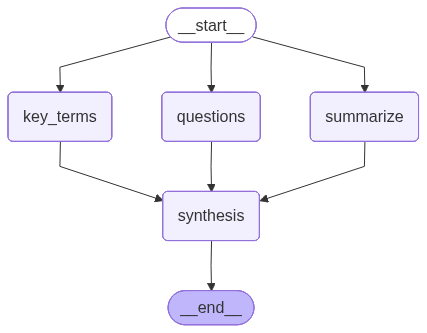

In [11]:
from IPython.display import Image, display

app = build_graph()
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
input_state = ParallelState(topic="포켓몬스터 시리즈")

final_state = app.invoke(
    input_state,
    config={"thread_id": "parallel-example"}
)

# 결과 출력
print("====== [SUMMARY] ======")
print(final_state.get("summary", ""))
print("\n====== [QUESTIONS] ======")
print(final_state.get("questions", ""))
print("\n====== [KEY TERMS] ======")
print(final_state.get("key_terms", ""))
print("\n====== [SYNTHESIS] ======")
print(final_state.get("synthesis", ""))


====== [SUMMARY] ======
포켓몬스터 시리즈는 게임 및 애니메이션으로 구성된 일본의 인기 콘텐츠로, 포켓몬을 수집하고 전투하는 이야기를 중심으로 전개됩니다. 이 시리즈는 전 세계적인 인기를 끌며, 다양한 플랫폼에서 게임이 출시되며, 애니메이션과 연관된 콘텐츠도 많이 있습니다.

====== [QUESTIONS] ======
포켓몬스터 시리즈는 전 세계적으로 사랑받는 게임 시리즈 중 하나입니다. 이 시리즈에 대해 어떤 면에서 가장 흥미로운 질문이 있을까요? 첫 번째 질문은, "포켓몬스터 시리즈에서 가장 강력한 포켓몬은 무엇인가요?"입니다. 이 질문은 팬들이 오래 전부터 논란을 일으키고 있는 주제입니다. 두 번째 질문은, "포켓몬스터 시리즈가 처음으로 출시된 시기와 이유는 무엇인가요?"입니다. 이는 게임의 역사와 발전을 이해하는 데 중요한 질문입니다. 마지막으로, "포켓몬스터 시리즈가 전 세계적으로 사랑받는 이유는 무엇인가요?"입니다. 이 질문은 시리즈의 성공 요인을 탐구하는 데 매우 유용합니다.

====== [KEY TERMS] ======
포켓몬스터, 포켓몬, 스타일, 캐릭터, 세계관, 게임, 애니메이션, 보물, 스토리, 캐릭터 디자인

====== [SYNTHESIS] ======
포켓몬스터 시리즈는 일본의 인기 콘텐츠로, 게임과 애니메이션을 통해 전 세계적으로 사랑받고 있습니다. 이 시리즈는 포켓몬을 수집하고 전투하는 이야기를 중심으로 전개되며, 다양한 플랫폼에서 게임이 출시되고 있습니다. 애니메이션과 연관된 콘텐츠도 풍부하며, 세계관과 스토리가 뛰어난 것이 특징입니다. 포켓몬스터 시리즈의 매력은 캐릭터 디자인과 스타일에서도 느껴질 수 있습니다. 또한, 보물과 관련된 이야기도 인기를 끌고 있습니다. 이 시리즈는 전 세계적으로 사랑받는 이유는 게임과 애니메이션의 조화로운 결합에서 비롯됩니다.

핵심 용어  
- 포켓몬스터  
- 포켓몬  
- 스타일  
- 캐릭터  
- 세계관  
- 게임  
- 애니메이션  
- 보물  
- 스토리  
-

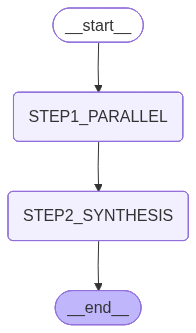

In [ ]:
def all_ready(state: ParallelState):
    return bool(state.get("summary") and state.get("questions") and state.get("key_terms"))

def barrier_noop(state: ParallelState) -> ParallelState:
    return {}

# 서브 그래프 빌더 ( 병렬 슈퍼-스텝 구현용 )
def build_step1_parallel_subgraph():
    g1 = StateGraph(ParallelState)

    g1.add_node("summarize", summarize_node)
    g1.add_node("questions", questions_node)
    g1.add_node("key_terms", key_terms_node)
    g1.add_node("barrier", barrier_noop)

    g1.add_edge(START, "summarize")
    g1.add_edge(START, "questions")
    g1.add_edge(START, "key_terms")

    g1.add_edge("summarize", "barrier")
    g1.add_edge("questions", "barrier")
    g1.add_edge("key_terms", "barrier")

    def route_from_barrier(state: ParallelState):
        return END if all_ready(state) else None

    g1.add_conditional_edges("barrier", route_from_barrier, path_map={END: END})

    return g1.compile()

# 메인 그래프 빌더
def build_pipeline():
    step1 = build_step1_parallel_subgraph()

    g = StateGraph(ParallelState)

    g.add_node("STEP1_PARALLEL", step1)
    g.add_node("STEP2_SYNTHESIS", synthesis_node)

    g.add_edge(START, "STEP1_PARALLEL")
    g.add_edge("STEP1_PARALLEL", "STEP2_SYNTHESIS")
    g.add_edge("STEP2_SYNTHESIS", END)

    memory = MemorySaver()
    return g.compile(checkpointer=memory)

app = build_pipeline()
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
init = ParallelState(topic="포켓몬스터 시리즈")
# MemorySaver 사용 시 thread_id를 반드시 전달
final = app.invoke(init, config={"thread_id": "superstep-demo"})

print("====== [SUMMARY] ======")
print(final.get("summary", ""))
print("\n====== [QUESTIONS] ======")
print(final.get("questions", ""))
print("\n====== [KEY TERMS] ======")
print(final.get("key_terms", ""))
print("\n====== [SYNTHESIS] ======")
print(final.get("synthesis", ""))

====== [SUMMARY] ======
포켓몬스터 시리즈는 게임 및 애니메이션으로 구성된 일본의 유명한 문화 시리즈로, 포켓몬을 주제로 한 어린이 체험형 콘텐츠입니다. 이 시리즈는 전 세계적으로 사랑받고, 다양한 플랫폼에서 게임과 애니메이션으로 지속적으로 발전하고 있습니다.

====== [QUESTIONS] ======
포켓몬스터 시리즈는 전 세계적으로 사랑받는 게임 시리즈 중 하나입니다. 그 중에서 가장 먼저 출시된 작품은 무엇인가요? 또한, 포켓몬스터 시리즈에서 가장 인기 있는 포켓몬은 어떤 것이고, 그 이유는 무엇인가요? 마지막으로, 포켓몬스터 시리즈가 지금까지 어떤 변화를 겪었는지 설명해 주세요.

====== [KEY TERMS] ======
포켓몬스터, 시리즈, 포켓몬, 게임, 애니메이션, 영화, 캐릭터, 스토리, 세계관, 캐치포인트

====== [SYNTHESIS] ======
포켓몬스터 시리즈는 일본의 유명한 문화 시리즈로, 게임과 애니메이션을 통해 전 세계적으로 사랑받고 있습니다. 이 시리즈는 포켓몬을 주제로 한 어린이 체험형 콘텐츠로, 다양한 플랫폼에서 지속적으로 발전하고 있습니다. 가장 먼저 출시된 작품은 1996년에 발매된 **포켓몬스터 레드/블루**입니다. 가장 인기 있는 포켓몬은 **파이리**로, 그 이유는 그의 독특한 외형과 강력한 능력 때문입니다. 또한, 시리즈는 시간이 지남에 따라 **영화**, **캐릭터**, **스토리**, **세계관** 등 다양한 요소에서 변화를 겪었으며, **캐치포인트**라는 새로운 개념을 도입해 게임의 재미를 향상시켰습니다.

핵심 용어  
- 포켓몬스터  
- 시리즈  
- 포켓몬  
- 게임  
- 애니메이션  
- 영화  
- 캐릭터  
- 스토리  
- 세계관  
- 캐치포인트
